Vector of ranking values $\mathbf{r}$, with values indicating strength of team i. 
$$s_i = \frac{1}{n_i} \sum_{j=i}^{N}a_{ij}r_j$$
$a_{i j}$ nonnegative number depending on outcome of game from matrix A, N total number of teams, $n_i$ number of games played by team i. 

A - matrix of game outcomes, $a_{i j}$ is 1 if team $i$ wins, 0.5 if it is a tie, and 0 if team $i$ loses. Normalizes data so teams cannot gain a higher score by playing more games. 

$\mathbf{r}$ is an eigenvector of A. 

The Perron-Frobenius Theorem: If A has nonnegative entries, then there exists an eigenvector with nonnegative values corresponding to a positive eigenvalue. If A is irreducible, then $\mathbf{r}$ has strictly pos entries, is unique and simple, and the corresponding eigenvalue is the largest eigenvalue of A in absolute value (equal to the spectral radius of A)

We can calculate $\mathbf{r}$ using the power method: 
$$\lim_{n \to \infty} \frac{A^n\mathbf{r}_0}{|A^n\mathbf{r}_0|} = \mathbf{r}$$
for any nonnegative vector $\mathbf{r}_0$.


About the data: This data is drawn from the 2015-2016 AFC West Season, with special guest the Detroit Lions because the San Diego Chargers are apparently terrible and were winless without them.

It was surprisingly difficult to find win and loss data for football, so this data needs a lot of preprocessing.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import glob
import operator

In [4]:
#Team names:
with open('team_data.csv', 'rt') as f:
    reader = csv.reader(f)
    teams = list(reader)
teams = np.sort(np.array(teams).flatten())

In [5]:
#Math Function Definitions:

def get_r(A, r_0, max_iter=1000):
    #USAGE: matrix of some win/loss metric A
    #       initial value r_0
    #       max_iter: if 1, returns Ar_0; if 2, returns A^2r_0, if large, returns limit as n-> inf of A^nr_0
    #RETURNS: approximate eigenvector r
    
    r_prev = np.zeros(len(A))
    for k in range(max_iter):
        A_k = np.linalg.matrix_power(A, k)
        r = A_k @ r_0 / np.linalg.norm(A_k @ r_0)
        if np.isclose(r, r_prev).all():
            break
        else:
            r_prev = r
    return r

def get_linear_scores(A, r):
    #USAGE: matrix of some win/loss metric A
    #       approx. eigenvector r
    #RETURNS: score vector S
    
    S = np.zeros(len(r))
    m, n = A.shape
    for i in range(m):
        for j in range(n):
            S[i] = 1/(len(A)-1) * A[i][j]*r[j]
    return S


def print_rankings(S, teams=teams):
    #USAGE: vector S of scores
    #RETURNS: None
    #Prints S and corresponding team names
    S = np.sort(S)[::-1] #sort high to low
    print("________Team Scores________")
    for i in range(len(teams)):
        print("{0}: {1:0.4f}".format(teams[i], S[i]))

**Function For Importing Data**

In [6]:
def import_data(data_column):
    #USAGE: takes in column to store in data matrix
    #RETURNS: data matrix
    
    path = "data/*.csv"

    allFiles = glob.glob(path)

    data = np.zeros((len(teams), len(teams))) #will store wins, losses here

    for file_ in allFiles:
    #     df = pd.read_csv(file_,index_col=None, header=0)
        #Get first line of file (team name):
        with open(file_) as f:
            reader = csv.reader(f)
            team_name = next(reader)[0]  #get name of team i  
        i = np.where(teams == team_name)[0][0] #index of team name in teams

        df = pd.read_csv(file_,skiprows=1) #skip first row
    #     df.head(5)

        #Data Processing: 
        #For now, change W -> 1, L -> 0, T or D (unsure of label in dataset) -> 0.5
        df.loc[df['win'] == "W", 'win'] = 1
        df.loc[df['win'] == "L", 'win'] = 0
    #     df.loc[df['win'] == "T", 'win'] = 0.5

        seen = set()
        for index, row in df.iterrows():
            #For now, get rid of teams not in AFC West:
            if row["opp"] not in teams:
    #             print(row["opp"])
                df.drop(index, inplace=True)
                continue

            #For now, drop second game: 
            elif row["opp"] not in seen:
                seen.add(row["opp"])
            else:
                df.drop(index, inplace=True)

                continue

            j = np.where(teams == row["opp"])[0][0] #index of opposing team name in teams
            data[i][j] = row[data_column]
    #         print(team_name, row["opp"], row["win"])


    data = data.T #to make not opposing team on columns
#     np.fill_diagonal(data, 0.5) #set all diagonal elements (where team i = team j) to 0.5
    return data

In [7]:
#Read in data:
data_wins = import_data("win")
#Using aij=1 if team i won, 0 if team i lost, 0.5 if tie:
A = data_wins.copy()

df_wins = pd.DataFrame(data_wins, index=teams, columns=teams)
df_wins.head(5)

,Denver Broncos,Detroit Lions,Kansas City Chiefs,Oakland Raiders,San Diego Chargers
Denver Broncos,0.0,0.0,0.0,0.0,0.0
Detroit Lions,1.0,0.0,1.0,0.0,1.0
Kansas City Chiefs,1.0,0.0,0.0,0.0,0.0
Oakland Raiders,1.0,1.0,1.0,0.0,0.0
San Diego Chargers,1.0,0.0,1.0,1.0,0.0


In [8]:
#Math: Variable definitions

#If we want Ar_0, set max_iter to 1. 
#If we want A^2r_0, set max_iter to 2
#If we want the limit as n approaches infinity, set max_iter to a large number
max_iter = 1000
r_0 = np.ones(len(A))
r = get_r(A, r_0, max_iter)
S = get_linear_scores(A, r)
print_rankings(S)

________Team Scores________
Denver Broncos: 0.1443
Detroit Lions: 0.0000
Kansas City Chiefs: 0.0000
Oakland Raiders: 0.0000
San Diego Chargers: 0.0000


In [9]:
#Recalculate A s.t. aij=(Sij+1)/(Sij+Sji+2)
def point_scoring(data):
    #USAGE: rank teams based on relative scores per game
    #INPUT: data matrix
    #RETURNS: scoring matrix A
    A = np.zeros(data.shape)

    m, n = data.shape
    for i in range(m):
        for j in range(n):
            A[i][j] = (data[i][j]+1) / (data[i][j] + data[j][i] + 2)
    return A
#will store each teams score here
data_points= import_data('sc')
#Process data:
# aij=(Sij+1)/(Sij+Sji+2)
A = point_scoring(data_points)

df_points = pd.DataFrame(A, index=teams, columns=teams)
df_points.head(5)

,Denver Broncos,Detroit Lions,Kansas City Chiefs,Oakland Raiders,San Diego Chargers
Denver Broncos,0.500000,0.342105,0.438596,0.392857,0.181818
Detroit Lions,0.657895,0.500000,0.807018,0.424242,0.539683
Kansas City Chiefs,0.561404,0.192982,0.500000,0.375000,0.105263
Oakland Raiders,0.607143,0.575758,0.625000,0.500000,0.441176
San Diego Chargers,0.818182,0.460317,0.894737,0.558824,0.500000


In [10]:
#Math: Variable definitions

max_iter = 1000
r_0 = np.ones(len(A))
r = get_r(A, r_0, max_iter)
S = get_linear_scores(A, r)
print_rankings(S)

________Team Scores________
Denver Broncos: 0.0750
Detroit Lions: 0.0695
Kansas City Chiefs: 0.0613
Oakland Raiders: 0.0253
San Diego Chargers: 0.0146


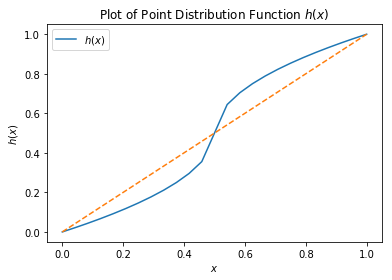

In [11]:
#Make nonlinear so that high scoring games dont overwhelm rankings:
def h(x):
    return 0.5 + 0.5 * np.sign(x - 1/2) * np.sqrt(abs(2*x - 1))
def point_scoring_nonlinear(data):
    #USAGE: rank teams based on relative scores per game
    #INPUT: data matrix
    #RETURNS: nonlinear scoring matrix A
    A = point_scoring(data)
    h_A = np.zeros(A.shape)
    m, n = A.shape
    for i in range(m):
        for j in range(n):
            h_A[i][j] = h(A[i][j])
    return h_A
#Plot of h vs x:
x = np.linspace(0, 1, 25)
y = np.linspace(0, 1, 25)
plt.plot(x, h(x), label=r'$h(x)$')
plt.plot(x, y, '--')
plt.title("Plot of Point Distribution Function $h(x)$")
plt.xlabel("$x$")
plt.ylabel("$h(x)$")
plt.legend()

In [12]:
#use same score-based data from before
data_nonlinear_points = data_points 
A = point_scoring_nonlinear(data_nonlinear_points)

df_points = pd.DataFrame(A, index=teams, columns=teams)
df_points.head(5)

,Denver Broncos,Detroit Lions,Kansas City Chiefs,Oakland Raiders,San Diego Chargers
Denver Broncos,0.500000,0.219024,0.324781,0.268545,0.101138
Detroit Lions,0.780976,0.500000,0.891802,0.305375,0.640859
Kansas City Chiefs,0.675219,0.108198,0.500000,0.250000,0.055738
Oakland Raiders,0.731455,0.694625,0.750000,0.500000,0.328501
San Diego Chargers,0.898862,0.359141,0.944262,0.671499,0.500000


In [13]:
max_iter = 1000
r_0 = np.ones(len(A))
r = get_r(A, r_0, max_iter)
S = get_linear_scores(A, r)
print_rankings(S)

________Team Scores________
Denver Broncos: 0.0916
Detroit Lions: 0.0715
Kansas City Chiefs: 0.0470
Oakland Raiders: 0.0145
San Diego Chargers: 0.0080


New formulation: to combat weak schedules, we have a new formula for determining the ranking vector $\mathbf{r}$:
$$ \mathbf{r}_i = \frac{1}{n_i} \sum_{j=1}^{N}f(e_{ij}r_j)$$
where $e_{ij}$ is a number determined from the outcome of the game between i, j; $r_j$ is the rank of team $j$; and $f$ is a monotonically increasing function where $f(0) = 0$, $f(\infty)=1$.

Define 
$$ F_i(\mathbf{r}) = \frac{1}{n_i} \sum_{j=1}^{N}f(e_{ij}r_j)$$

If $f(0) > 0$, and $f$ is strictly concave s.t. $\forall_{t \in (0, 1)} f(tx) > tf(x)$, then there is a unique, fixed point of the map $F(\mathbf{r})$ where for any positive inital vector $\mathbf{r}_0$:
$$ \lim_{n \to \infty} F^n(\mathbf{r}_0) = \mathbf{r}$$

An example function $f$:
$$ f(x) = \frac{0.05x + x^2}{2+0.05x+x^2}$$

An example function for determining $e_{ij}$:
$$e_{ij} = \frac{5 + S_{ij} + S_{ij}^{\frac{2}{3}}}{5 + S_{ji} + S_{ij}^{\frac{2}{3}}}$$

In [14]:
def adjusted_ranking(S, A, r):
    R = np.zeros(len(r))
    m,n = A.shape
    e = np.zeros(A.shape)
    for i in range(m):
        for j in range(n):
            e[i][j] = (5+A[i][j]+A[i][j]**(2/3))/(5+A[j][i]+A[i][j]**(2/3))
            x = e[i][j]*r[j]
            f = (0.05*x+x**2)/(2+0.05*x+x**2)
            R[i] = 1/(len(A)-1)*f
    return R


In [15]:
R = adjusted_ranking(S,A,r)
print_rankings(R)


________Team Scores________
Denver Broncos: 0.0406
Detroit Lions: 0.0378
Kansas City Chiefs: 0.0344
Oakland Raiders: 0.0300
San Diego Chargers: 0.0291
